### Imports

In [1]:
import os
from pathlib import Path
import time
from dataclasses import dataclass
from typing import Optional
import copy

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from sklearn.decomposition import PCA
import matplotlib.gridspec as gridspec

# DICL
from dicl import dicl, adapters
from dicl.icl import iclearner as icl
from dicl.utils.main_script import (
    load_moment_model,
    load_moirai_model,
)

os.environ["HF_HOME"] = "/mnt/vdb/hugguingface/"

## Arguments

In [2]:
@dataclass
class Args:
    is_fine_tuned: bool = False
    forecast_horizon: int = 96
    model_name: str = "AutonLab/MOMENT-1-small"  # f"Salesforce/moirai-1.1-R-large"
    context_length: int = 512
    dataset_name: str = "ETTh1"  # Will be set based on forecast_horizon
    adapter: Optional[str] = None  # "pca"
    data_path: Path = Path("/mnt/vdb/abenechehab/dicl-adapters/results/data.csv")
    seed: int = 13
    device: str = "cpu"
    logger_name: str = "DICL Adapter"
    log_level: str = "INFO"
    log_dir: Path = Path("/mnt/vdb/abenechehab/dicl-adapters/logs")
    number_n_comp_to_try: int = 4
    inference_batch_size: int = 512
    supervised: bool = False


args = Args()

## Data

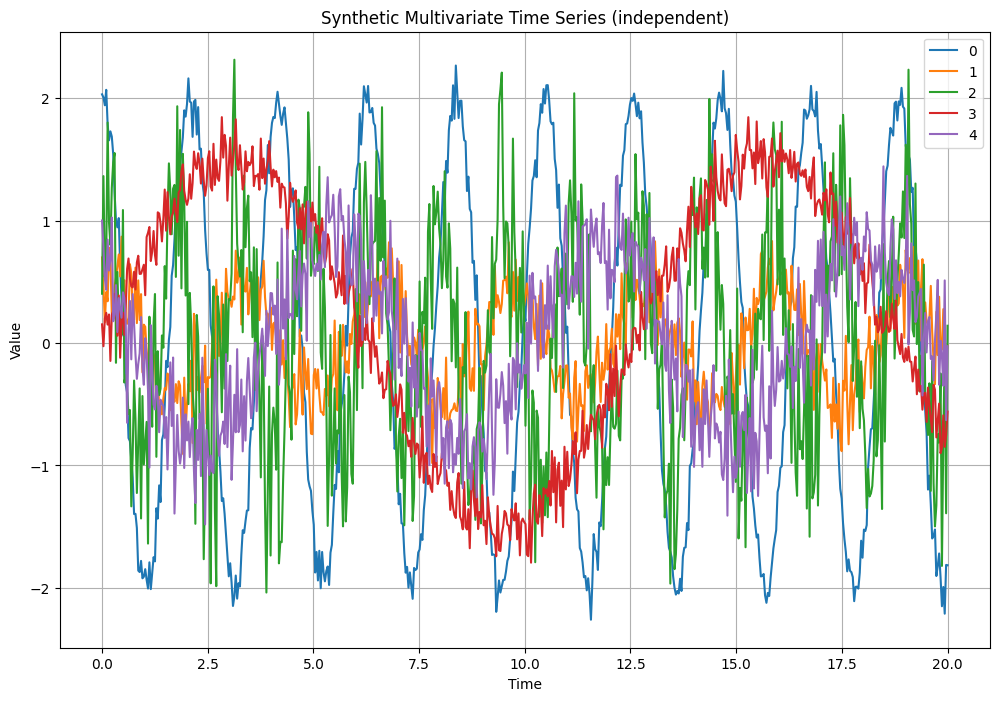

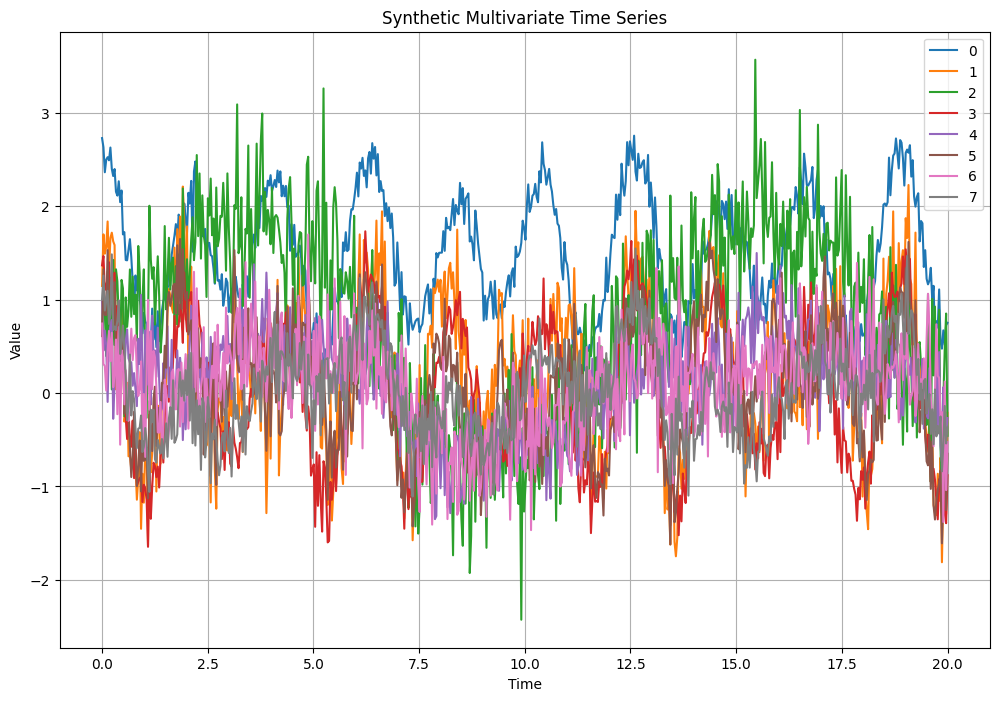

,0,1,2,3,4,5,6,7
0,2.731110,1.147121,0.623841,1.367914,0.978667,0.610310,0.745035,1.001020
1,2.633476,1.699982,1.095671,1.467468,0.453005,1.326503,0.311485,1.258275
2,2.365199,1.492755,0.861528,1.104094,0.669780,0.838966,0.289449,0.884786
3,2.500454,1.565693,0.396307,1.140107,0.506178,0.835151,0.026332,0.985659
4,2.526523,1.837902,1.304433,1.236656,-0.094652,1.530650,0.431029,1.094315


In [4]:
# Parameters
n_timesteps = args.context_length + args.forecast_horizon
xtime = np.linspace(0, 20, n_timesteps)

# Generate multivariate time series
# Generate independent source signals
i1 = 2.0 * np.cos(3.0 * xtime) + np.random.normal(0, 0.1, n_timesteps)
i2 = 0.5 * np.sin(2.0 * xtime + np.pi / 3) + np.random.normal(0, 0.2, n_timesteps)
i3 = np.cos(4.0 * xtime - np.pi / 6) + np.random.normal(0, 0.5, n_timesteps)
i4 = 1.5 * np.sin(0.5 * xtime) + np.random.normal(0, 0.15, n_timesteps)
i5 = 0.8 * np.cos(xtime + np.pi / 4) + np.random.normal(0, 0.3, n_timesteps)

# Add random trends to each source
# slope = np.random.uniform(-0.1, 0.1, 5)
# i1 += slope[0] * xtime
# i2 += slope[1] * xtime
# i3 += slope[2] * xtime
# i4 += slope[3] * xtime
# i5 += slope[4] * xtime

# Linear combinations with noise
x1 = 0.6 * i2 + 0.4 * i1 + 1.5 + np.random.normal(0, 0.1, n_timesteps)
x2 = 0.7 * i3 + 0.3 * i1 + 0.2 + np.random.normal(0, 0.2, n_timesteps)
x3 = 0.9 * i4 + 0.1 * i5 + 0.5 + np.random.normal(0, 0.5, n_timesteps)
x4 = 0.5 * i1 + 0.3 * i2 + 0.2 * i3 + np.random.normal(0, 0.15, n_timesteps)
x5 = 0.4 * i2 + 0.4 * i4 + 0.2 * i5 + np.random.normal(0, 0.3, n_timesteps) 
x6 = 0.6 * i3 + 0.2 * i4 + 0.2 * i1 + np.random.normal(0, 0.1, n_timesteps)
x7 = 0.3 * i4 + 0.3 * i5 + 0.4 * i2 + np.random.normal(0, 0.4, n_timesteps)
x8 = 0.5 * i5 + 0.2 * i1 + 0.1 * i3 + 0.3 * i2 + np.random.normal(0, 0.2, n_timesteps)


# Combine into a DataFrame for visualization and analysis
multivariate_ts = pd.DataFrame(
    np.concatenate([eval(f"x{i+1}").reshape(-1, 1) for i in range(8)], axis=1),
)
multivariate_ts_id = pd.DataFrame(
    np.concatenate([eval(f"i{i+1}").reshape(-1, 1) for i in range(5)], axis=1),
)

# Plot the time series
plt.figure(figsize=(12, 8))
for col in multivariate_ts_id.columns:
    plt.plot(xtime, multivariate_ts_id[col], label=col)
plt.title("Synthetic Multivariate Time Series (independent)")
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()
plt.grid()

plt.figure(figsize=(12, 8))
for col in multivariate_ts.columns:
    plt.plot(xtime, multivariate_ts[col], label=col)
plt.title("Synthetic Multivariate Time Series")
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()
plt.grid()
plt.show()

# Display a few rows of the dataset
multivariate_ts.head()

In [5]:
def df_to_ts(df):
    time_series = np.expand_dims(df.values, axis=0)
    time_series = time_series.swapaxes(1, 2)

    X_test = copy.copy(time_series[:, :, : -args.forecast_horizon])
    y_test = copy.copy(time_series[:, :, -args.forecast_horizon :])
    X_train, y_train = copy.copy(X_test), copy.copy(y_test)

    n_features = time_series.shape[1]

    return X_train, y_train, X_test, y_test, n_features

X_train, y_train, X_test, y_test, n_features = df_to_ts(multivariate_ts_id) # multivariate_ts_id

## Random linear FM

In [6]:
def f_FM(X, w_FM, b_FM):
    return w_FM.T @ X + b_FM @ np.ones((X.shape[1], 1)).T

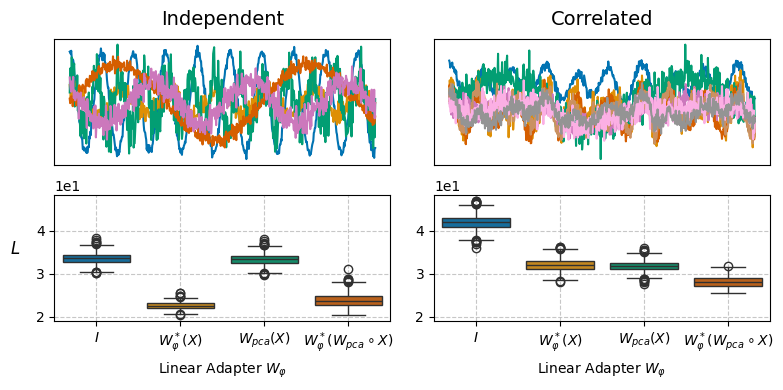

In [7]:
n_samples = 1000
colors = sns.color_palette("colorblind")
fig = plt.figure(figsize=(8, 4))
gs = gridspec.GridSpec(2, 2)
ax0 = fig.add_subplot(gs[0, 0])  # First subplot (independent)
ax1 = fig.add_subplot(gs[0, 1])  # Second subplot
ax2 = fig.add_subplot(gs[1, 0])  # Third subplot (will share y with fourth)
ax3 = fig.add_subplot(gs[1, 1], sharey=ax2)  # Fourth subplot shares y with third
axes = [ax0, ax1, ax2, ax3]
for idx, col in enumerate(multivariate_ts_id.columns):
    axes[0].plot(xtime, multivariate_ts_id[col], color=colors[idx])
# Remove ticks and labels
axes[0].set_xticks([])  # Remove x-axis ticks
axes[0].set_yticks([])  # Remove y-axis ticks
axes[0].set_xticklabels([])  # Remove x-axis labels
axes[0].set_yticklabels([])  # Remove y-axis labels
axes[0].set_title("Independent", fontsize=14, pad=10)
axes[0].grid(True, linestyle="--", alpha=0.7)
for idx, col in enumerate(multivariate_ts.columns):
    axes[1].plot(xtime, multivariate_ts[col], color=colors[idx])
axes[1].set_xticks([])  # Remove x-axis ticks
axes[1].set_yticks([])  # Remove y-axis ticks
axes[1].set_xticklabels([])  # Remove x-axis labels
axes[1].set_yticklabels([])  # Remove y-axis labels
axes[1].set_title("Correlated", fontsize=14, pad=10)
axes[1].grid(True, linestyle="--", alpha=0.7)
for i, df in enumerate([multivariate_ts_id, multivariate_ts]):
    X_train, y_train, X_test, y_test, n_features = df_to_ts(
        df
    )

    baseline_losses = []
    optimal_losses = []
    pca_losses = []
    optimal_pca_losses = []
    for _ in range(n_samples):
        # Option 2: Glorot/Xavier initialization (commonly used in neural nets)
        limit = np.sqrt(6 / (args.context_length + args.forecast_horizon))
        w_FM = np.random.uniform(-limit, limit, (args.context_length, args.forecast_horizon))
        b_FM = np.random.normal(0, 0.1, (args.forecast_horizon, 1))

        X, y = X_train.squeeze().swapaxes(0, 1), y_train.squeeze().swapaxes(0, 1)
        L_baseline = np.linalg.norm(y - f_FM(X, w_FM, b_FM), ord="fro")
        A = y - w_FM.T @ X
        B = b_FM @ np.ones((n_features, 1)).T
        # print(f"determinant of B.T @ A: {np.linalg.det(B.T @ A)}")
        B_BT_inv = np.linalg.inv(B.T @ A + 0.0001 * np.eye(n_features))
        w_phi_star = B_BT_inv @ B.T @ B
        L_star = np.linalg.norm(
            y
            - (
                f_FM(X @ w_phi_star, w_FM, b_FM)
                @ np.linalg.inv(w_phi_star + 0.0001 * np.eye(n_features))
            ),
            ord="fro",
        )
        # print(f"Baseline loss: {L_baseline}")
        # print(f"Optimal loss: {L_star}")
        # print(f"norm of w_phi_star: {np.linalg.norm(w_phi_star, ord='fro')}")
        # pca
        pca = PCA(n_components=n_features)
        pca.fit(X)
        L_pca = np.linalg.norm(
            y - pca.inverse_transform(f_FM(pca.transform(X), w_FM, b_FM)), ord="fro"
        )
        # print(f"PCA loss: {L_pca}")

        # solve optimal for pca transformed data
        A_pca = y - w_FM.T @ pca.transform(X)
        # print(f"determinant of B.T @ A: {np.linalg.det(B.T @ A)}")
        B_BT_inv = np.linalg.pinv(B.T @ A_pca)# + 0.0001 * np.eye(n_features))
        w_phi_star_pca = B_BT_inv @ B.T @ B
        L_star_pca = np.linalg.norm(
            y
            - (
                f_FM(pca.transform(X) @ w_phi_star_pca, w_FM, b_FM)
                @ np.linalg.pinv(w_phi_star_pca )#+ 0.0001 * np.eye(n_features))
            ),
            ord="fro",
        )

        baseline_losses.append(L_baseline)
        optimal_losses.append(L_star)
        pca_losses.append(L_pca)
        optimal_pca_losses.append(L_star_pca)

    data = {
        r"$I$": baseline_losses,
        r"$W_{\varphi}^*(X)$": optimal_losses,
        r"$W_{pca}(X)$": pca_losses,
        r"$W_{\varphi}^*(W_{pca} \circ X)$": optimal_pca_losses,
    }
    # Use a colorblind-friendly and professional color palette
    palette = "colorblind"
    
    # Create the boxplot with enhanced settings
    sns.boxplot(data=data, ax=axes[i+2], palette=palette)
    
    # Customize the appearance
    axes[i + 2].set_xlabel(r"Linear Adapter $W_{\varphi}$", fontsize=10)
    axes[i + 2].tick_params(axis="both", which="major", labelsize=10)
    
    # Add grid for better readability
    axes[i + 2].grid(True, linestyle="--", alpha=0.7)

# Set common labels
axes[2].set_ylabel(r'$L$', fontsize=12, rotation=0, labelpad=15)
axes[2].ticklabel_format(style="sci", axis="y", scilimits=(0, 0))
# axes[3].set_yticklabels([])  # Remove y-axis labels

# Adjust layout to prevent label cutoff
plt.tight_layout()
plt.savefig(
    "/mnt/vdb/abenechehab/dicl-adapters/figures/from_notebooks/linear_synthetic.pdf",
    dpi=300,
    bbox_inches="tight",
)
plt.show()

## Visualize predicted trajectories

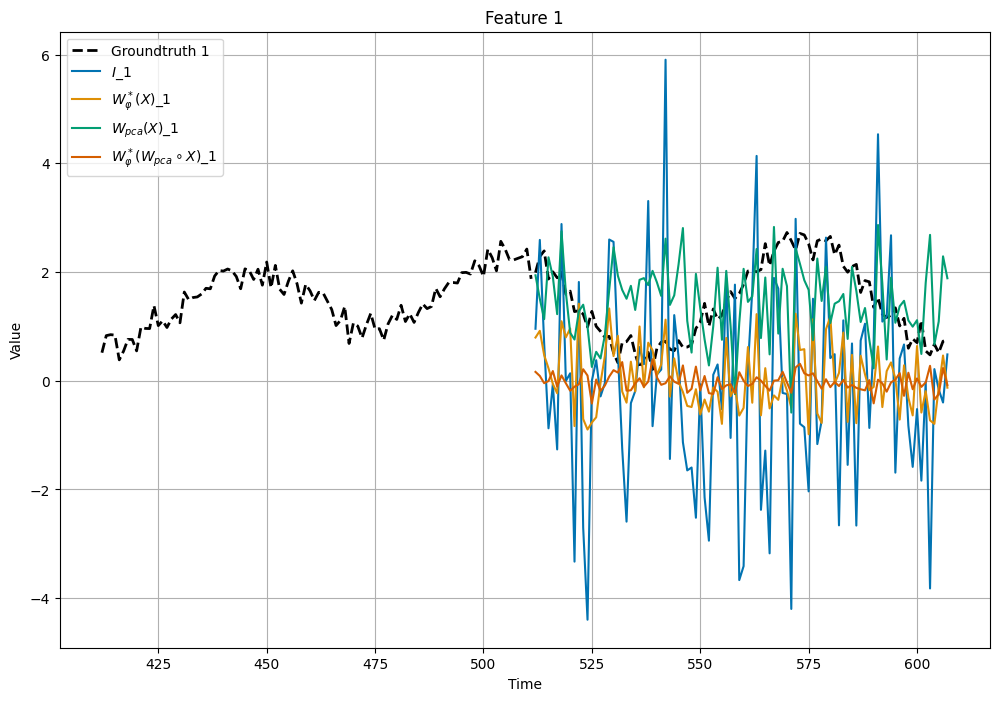

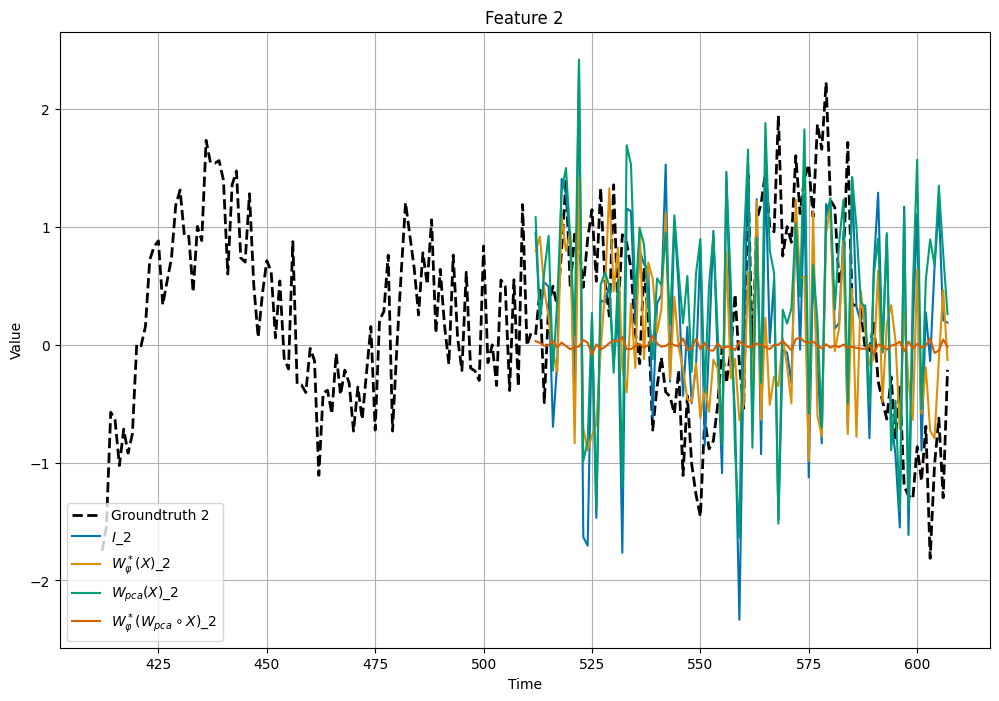

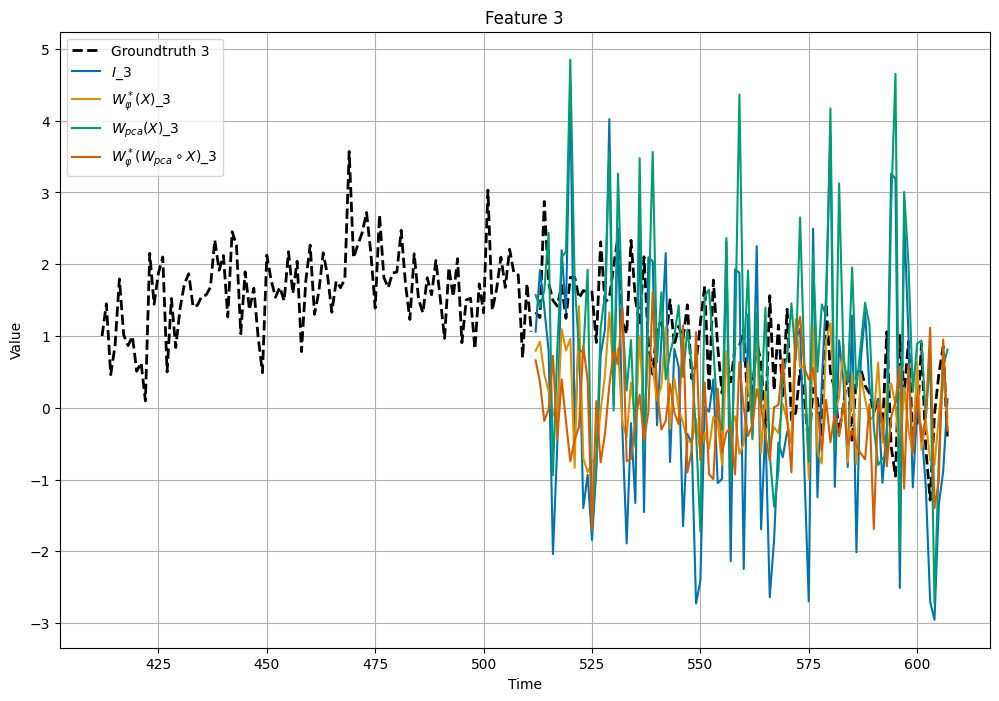

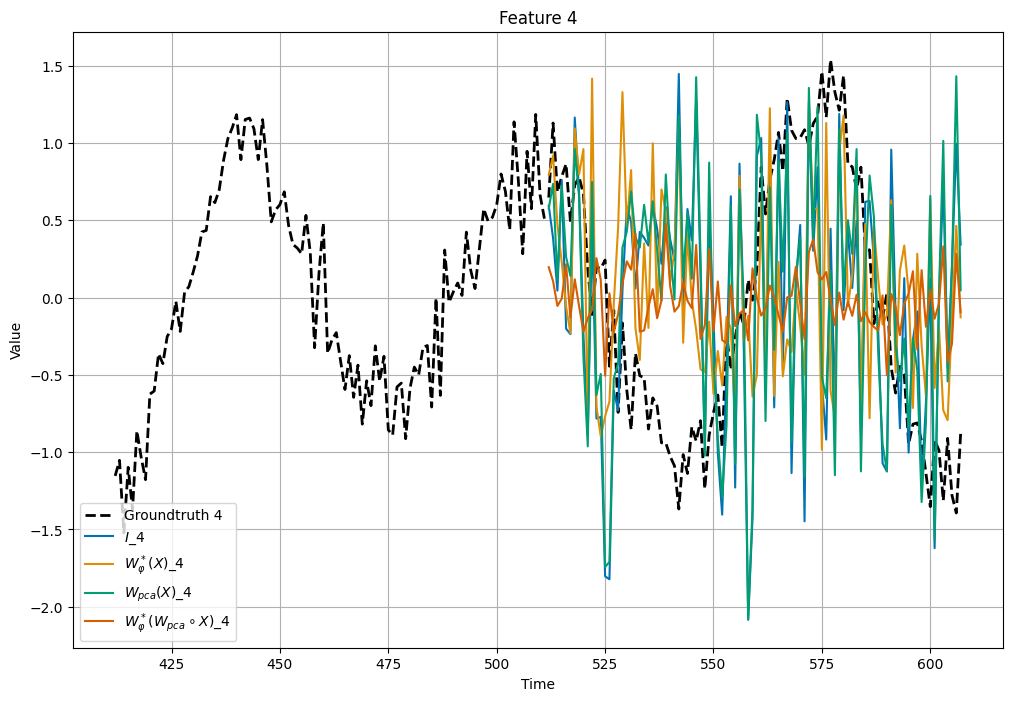

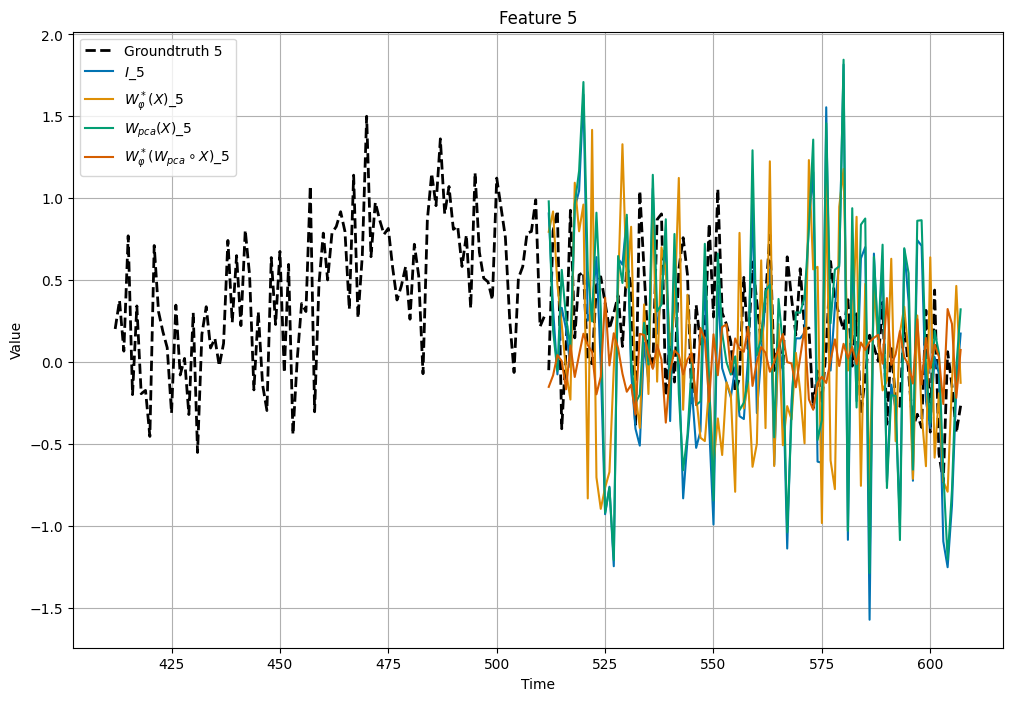

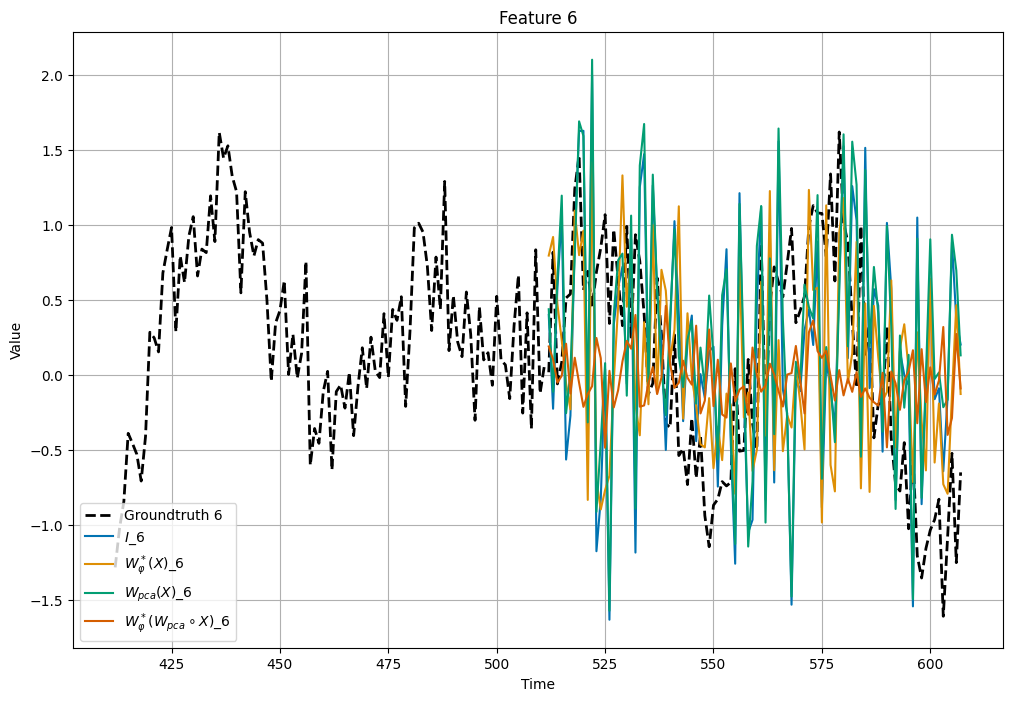

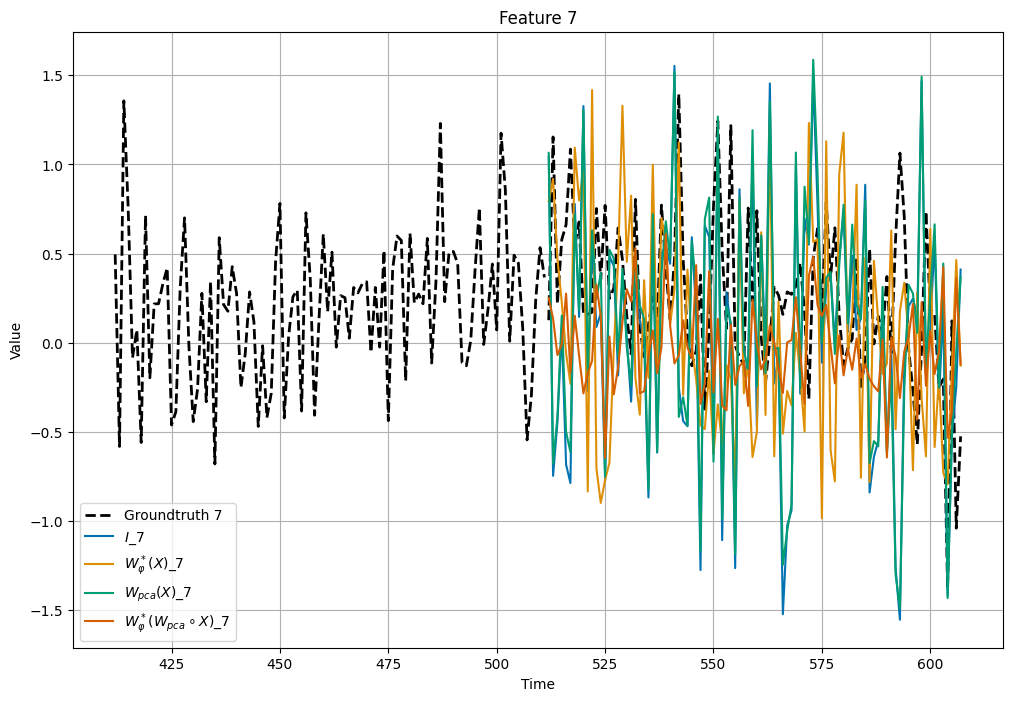

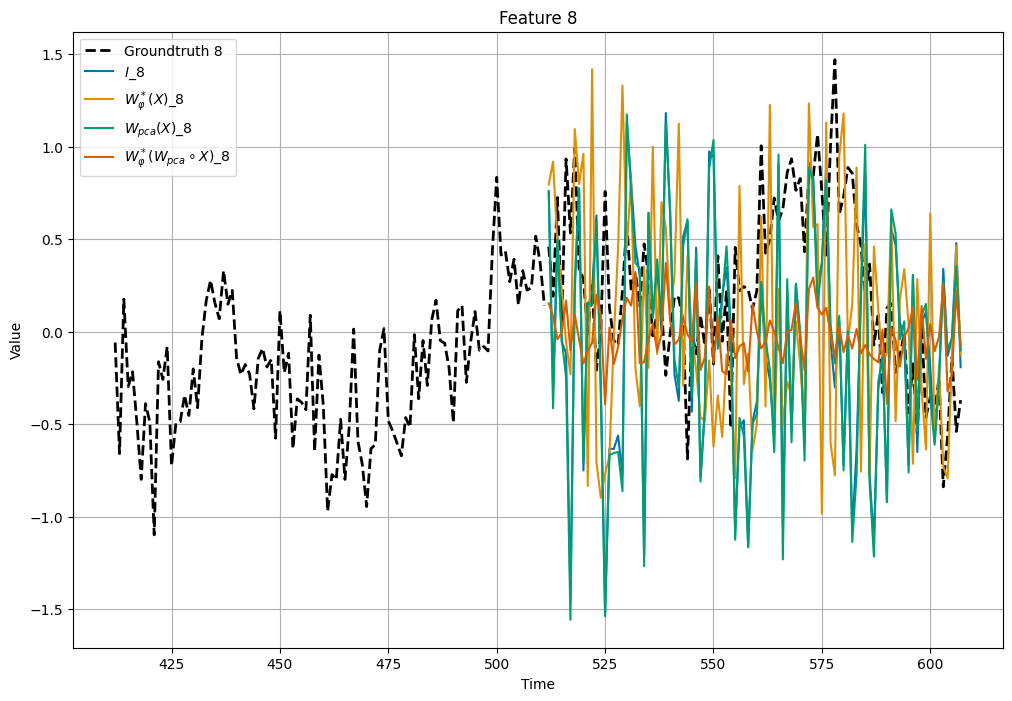

In [ ]:
df = multivariate_ts  # multivariate_ts

X_train, y_train, X_test, y_test, n_features = df_to_ts(df)

# Option 2: Glorot/Xavier initialization (commonly used in neural nets)
limit = np.sqrt(6 / (args.context_length + args.forecast_horizon))
w_FM = np.random.uniform(
    -limit, limit, (args.context_length, args.forecast_horizon)
)
b_FM = np.random.normal(0, 0.1, (args.forecast_horizon, 1))

X, y = X_train.squeeze().swapaxes(0, 1), y_train.squeeze().swapaxes(0, 1)
L_baseline = np.linalg.norm(y - f_FM(X, w_FM, b_FM), ord="fro")
A = y - w_FM.T @ X
B = b_FM @ np.ones((n_features, 1)).T
# print(f"determinant of B.T @ A: {np.linalg.det(B.T @ A)}")
B_BT_inv = np.linalg.inv(B.T @ A + 0.0001 * np.eye(n_features))
w_phi_star = B_BT_inv @ B.T @ B
y_star = f_FM(X @ w_phi_star, w_FM, b_FM) @ np.linalg.inv(w_phi_star + 0.0001 * np.eye(n_features))

# pca
pca = PCA(n_components=n_features)
pca.fit(X)
y_pca = pca.inverse_transform(f_FM(pca.transform(X), w_FM, b_FM))

# solve optimal for pca transformed data
A_pca = y - w_FM.T @ pca.transform(X)
# print(f"determinant of B.T @ A: {np.linalg.det(B.T @ A)}")
B_BT_inv = np.linalg.pinv(B.T @ A_pca)  # + 0.0001 * np.eye(n_features))
w_phi_star_pca = B_BT_inv @ B.T @ B
y_star_pca = f_FM(pca.transform(X) @ w_phi_star_pca, w_FM, b_FM) @ np.linalg.pinv(w_phi_star_pca)

include_from_x = 100
for idx in range(n_features):
    x_ts = np.arange(X.shape[0])
    plt.figure(figsize=(12, 8))
    plt.plot(
        np.arange(args.context_length - include_from_x, args.context_length),
        X[-include_from_x:, idx],
        linestyle="--",
        color="black",
        linewidth=2,
    )
    plt.plot(
        np.arange(args.context_length, args.context_length+args.forecast_horizon),
        y[:, idx],
        label=f"Groundtruth {idx+1}",
        linestyle="--",
        color="black",
        linewidth=2,
    )
    plt.plot(
        np.arange(args.context_length, args.context_length + args.forecast_horizon),
        f_FM(X, w_FM, b_FM)[:, idx],
        label=r"$I$" + f"_{idx+1}",
        color=colors[0],
    )
    plt.plot(
        np.arange(args.context_length, args.context_length + args.forecast_horizon),
        y_star[:, idx],
        label=r"$W_{\varphi}^*(X)$" + f"_{idx+1}",
        color=colors[1],
    )
    plt.plot(
        np.arange(args.context_length, args.context_length + args.forecast_horizon),
        y_pca[:, idx],
        label=r"$W_{pca}(X)$" + f"_{idx+1}",
        color=colors[2],
    )
    plt.plot(
        np.arange(args.context_length, args.context_length + args.forecast_horizon),
        y_star_pca[:, idx],
        label=r"$W_{\varphi}^*(W_{pca} \circ X)$" + f"_{idx+1}",
        color=colors[3],
    )
    plt.title(f"Feature {idx+1}")
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.legend()
    plt.grid()
plt.show()


## Visualize adapters (representation learning)

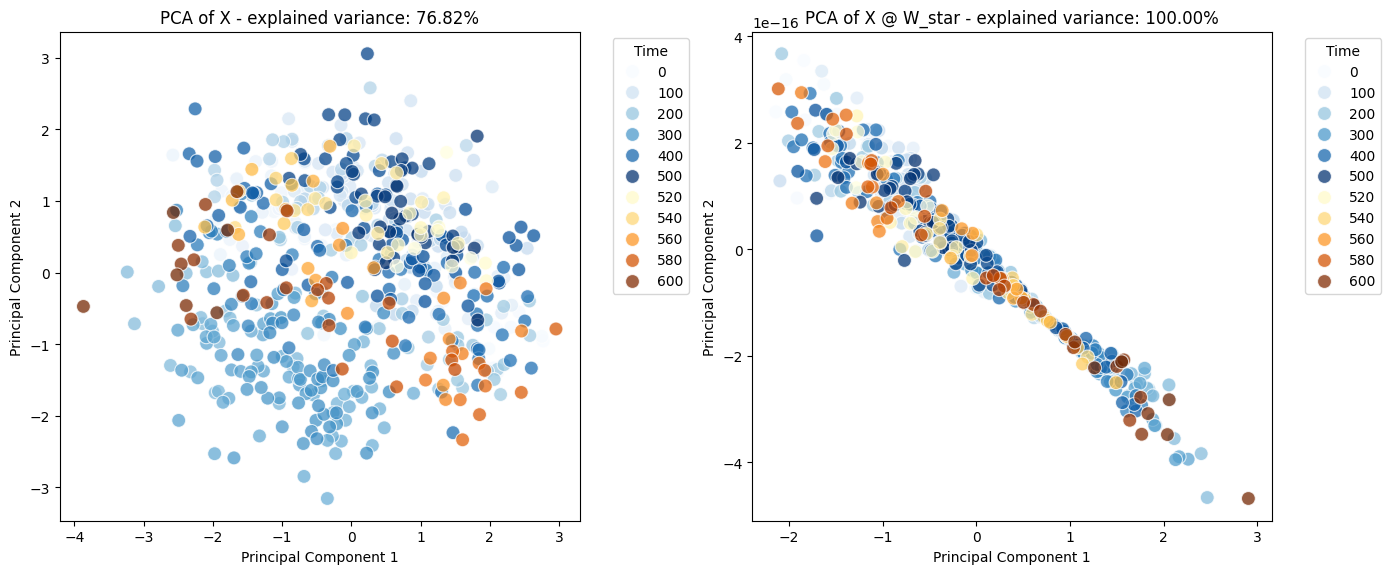

In [38]:
from sklearn.decomposition import PCA
import seaborn as sns

df = multivariate_ts  # multivariate_ts

X_train, y_train, X_test, y_test, n_features = df_to_ts(df)

# Option 2: Glorot/Xavier initialization (commonly used in neural nets)
limit = np.sqrt(6 / (args.context_length + args.forecast_horizon))
w_FM = np.random.uniform(-limit, limit, (args.context_length, args.forecast_horizon))
b_FM = np.random.normal(0, 0.1, (args.forecast_horizon, 1))

X, y = X_train.squeeze().swapaxes(0, 1), y_train.squeeze().swapaxes(0, 1)
L_baseline = np.linalg.norm(y - f_FM(X, w_FM, b_FM), ord="fro")
A = y - w_FM.T @ X
B = b_FM @ np.ones((n_features, 1)).T
# print(f"determinant of B.T @ A: {np.linalg.det(B.T @ A)}")
B_BT_inv = np.linalg.inv(B.T @ A + 1.0 * np.eye(n_features))
w_phi_star = B_BT_inv @ B.T @ B

# Apply PCA to X
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)
y_pca = pca.transform(y)
# Compute the amount of explained variance by PCA
explained_variance = pca.explained_variance_ratio_

# Transform X using W_star
X_transformed = X @ w_phi_star

# Apply PCA to the transformed data
pca = PCA(n_components=2)
X_transformed_pca = pca.fit_transform(X_transformed)
y_transformed_pca = pca.transform(y @ w_phi_star)
explained_variance_transformed = pca.explained_variance_ratio_

# Prepare data for plotting
X_pca_df = pd.DataFrame(X_pca, columns=["PC1", "PC2"])
X_pca_df["time"] = np.arange(X.shape[0])
y_pca_df = pd.DataFrame(y_pca, columns=["PC1", "PC2"])
y_pca_df["time"] = np.arange(X.shape[0], X.shape[0] + y.shape[0])

X_transformed_pca_df = pd.DataFrame(X_transformed_pca, columns=["PC1", "PC2"])
X_transformed_pca_df["time"] = np.arange(X.shape[0])
y_transformed_pca_df = pd.DataFrame(y_transformed_pca, columns=["PC1", "PC2"])
y_transformed_pca_df["time"] = np.arange(X.shape[0], X.shape[0] + y.shape[0])

# Plot the first two principal components
plt.figure(figsize=(14, 6))

# Plot X
plt.subplot(1, 2, 1)
sns.scatterplot(
    data=X_pca_df, x="PC1", y="PC2", hue="time", palette="Blues", alpha=0.75, s=100
)
sns.scatterplot(
    data=y_pca_df,
    x="PC1",
    y="PC2",
    hue="time",
    palette="YlOrBr",
    alpha=0.75,
    s=100,
)
plt.title(f"PCA of X - explained variance: {sum(explained_variance)*100:.2f}%")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Time", bbox_to_anchor=(1.05, 1), loc="upper left")

# Plot X @ W_star
plt.subplot(1, 2, 2)
sns.scatterplot(
    data=X_transformed_pca_df, x="PC1", y="PC2", hue="time", palette="Blues", alpha=0.75, s=100
)
sns.scatterplot(
    data=y_transformed_pca_df,
    x="PC1",
    y="PC2",
    hue="time",
    palette="YlOrBr",
    alpha=0.75,
    s=100,
)
plt.title(
    f"PCA of X @ W_star - explained variance: {sum(explained_variance_transformed)*100:.2f}%"
)
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Time", bbox_to_anchor=(1.05, 1), loc="upper left")

plt.tight_layout()
plt.show()

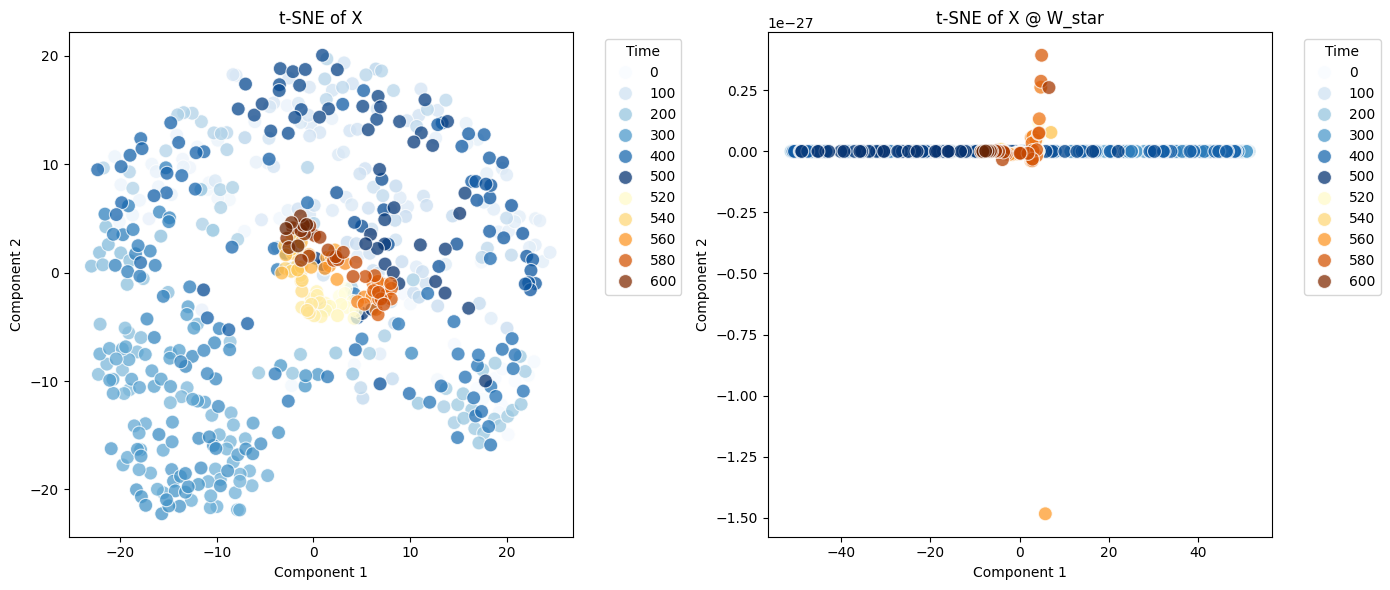

In [39]:
from sklearn.manifold import TSNE

# Apply t-SNE to X
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X)
y_tsne = tsne.fit_transform(y)

# Transform X using W_star
X_transformed = X @ w_phi_star
tsne = TSNE(n_components=2, random_state=42)
X_transformed_tsne = tsne.fit_transform(X_transformed)
y_transformed_tsne = tsne.fit_transform(y @ w_phi_star)

# Prepare data for plotting
X_tsne_df = pd.DataFrame(X_tsne, columns=["Component 1", "Component 2"])
X_tsne_df["time"] = np.arange(X.shape[0])
y_tsne_df = pd.DataFrame(y_tsne, columns=["Component 1", "Component 2"])
y_tsne_df["time"] = np.arange(X.shape[0], X.shape[0] + y.shape[0])

X_transformed_tsne_df = pd.DataFrame(
    X_transformed_tsne, columns=["Component 1", "Component 2"]
)
X_transformed_tsne_df["time"] = np.arange(X.shape[0])
y_transformed_tsne_df = pd.DataFrame(
    y_transformed_tsne, columns=["Component 1", "Component 2"]
)
y_transformed_tsne_df["time"] = np.arange(X.shape[0], X.shape[0] + y.shape[0])

# Plot using t-SNE
plt.figure(figsize=(14, 6))

# Plot X
plt.subplot(1, 2, 1)
sns.scatterplot(
    data=X_tsne_df,
    x="Component 1",
    y="Component 2",
    hue="time",
    palette="Blues",
    alpha=0.75,
    s=100,
)
sns.scatterplot(
    data=y_tsne_df,
    x="Component 1",
    y="Component 2",
    hue="time",
    palette="YlOrBr",
    alpha=0.75,
    s=100,
)
plt.title("t-SNE of X")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.legend(title="Time", bbox_to_anchor=(1.05, 1), loc="upper left")

# Plot X @ W_star
plt.subplot(1, 2, 2)
sns.scatterplot(
    data=X_transformed_tsne_df,
    x="Component 1",
    y="Component 2",
    hue="time",
    palette="Blues",
    alpha=0.75,
    s=100,
)
sns.scatterplot(
    data=y_transformed_tsne_df,
    x="Component 1",
    y="Component 2",
    hue="time",
    palette="YlOrBr",
    alpha=0.75,
    s=100,
)
plt.title("t-SNE of X @ W_star")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.legend(title="Time", bbox_to_anchor=(1.05, 1), loc="upper left")

plt.tight_layout()
plt.show()


Eigenvalues of w_phi_star (sorted by magnitude):
λ1 = 0.812620
λ2 = 0.000000
λ3 = 0.000000
λ4 = 0.000000
λ5 = 0.000000
λ6 = 0.000000
λ7 = 0.000000
λ8 = 0.000000

Condition number: inf


/tmp/ipykernel_3351327/2208238535.py:13: RuntimeWarning: divide by zero encountered in scalar divide
  condition_number = sorted_eigenvalues[0] / sorted_eigenvalues[-1]


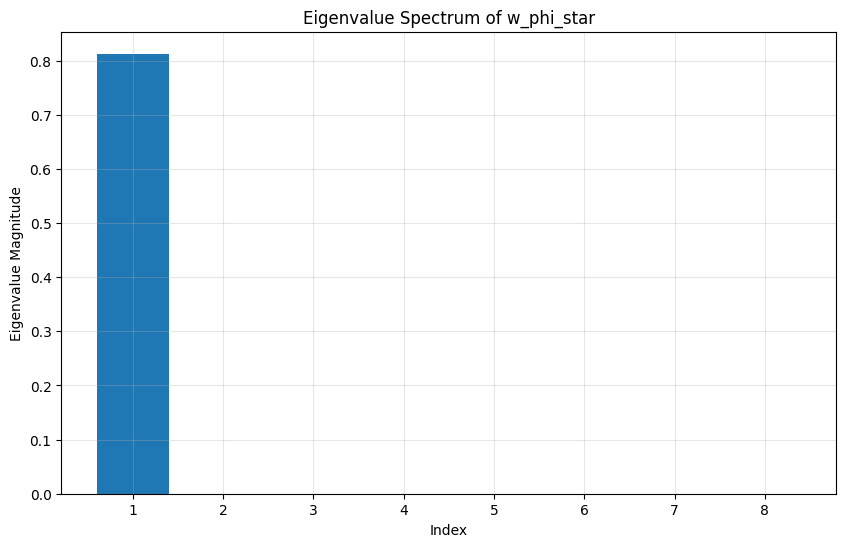

In [40]:
# Calculate eigenvalues of w_phi_star
eigenvalues = np.linalg.eigvals(w_phi_star)

# Sort eigenvalues by magnitude
sorted_eigenvalues = sorted(np.abs(eigenvalues), reverse=True)

# Print eigenvalues
print("Eigenvalues of w_phi_star (sorted by magnitude):")
for i, val in enumerate(sorted_eigenvalues):
    print(f"λ{i+1} = {val:.6f}")

# Print ratio of largest to smallest eigenvalue (condition number)
condition_number = sorted_eigenvalues[0] / sorted_eigenvalues[-1]
print(f"\nCondition number: {condition_number:.2f}")

# Create bar plot of eigenvalues
plt.figure(figsize=(10, 6))
plt.bar(range(1, len(sorted_eigenvalues) + 1), sorted_eigenvalues)
plt.xlabel('Index')
plt.ylabel('Eigenvalue Magnitude')
plt.title('Eigenvalue Spectrum of w_phi_star')
plt.grid(True, alpha=0.3)
plt.show()

## DICL

In [5]:
# df = pd.DataFrame()
df1 = pd.DataFrame()

In [6]:
adapter_list = [None, "pca", "rand", "linearAE"]  # 'svd'
n_seeds = 5
for adapter in adapter_list:
    for _ in range(n_seeds):
        seed = np.random.randint(0, 1000)
        np.random.seed(seed)
        torch.manual_seed(seed)

        for n_components in range(1 if adapter else 5, 6):
            model_loaded = False
            if (not model_loaded) or args.is_fine_tuned:
                model_loaded = True
                if "MOMENT" in args.model_name:
                    model = load_moment_model(
                        args.model_name, args.forecast_horizon
                    ).to(torch.device(args.device))
                    icl_constructor = icl.MomentICLTrainer
                elif "moirai" in args.model_name:
                    model = load_moirai_model(
                        args.model_name, args.forecast_horizon, args.context_length
                    ).to(torch.device(args.device))
                    icl_constructor = icl.MoiraiICLTrainer
                elif "ttm" in args.model_name:
                    raise NotImplementedError("TTM backbone not implemented yet")
                else:
                    raise ValueError(f"Not supported model: {args.model_name}")

            disentangler = adapters.MultichannelProjector(
                num_channels=n_features,
                new_num_channels=n_components,
                patch_window_size=None,
                base_projector=adapter,
                device=args.device,
            )

            iclearner = icl_constructor(
                model=model,
                n_features=n_components,
                forecast_horizon=args.forecast_horizon,
            )

            DICL = dicl.DICL(
                disentangler=disentangler,
                iclearner=iclearner,
                n_features=n_features,
                n_components=n_components,
            )

            next_time_cp = time.time()
            if args.supervised:
                # assert not args.is_fine_tuned, "iclearner must be frozen when adapter is "
                # "(supervised) fine-tuned"
                DICL.adapter_supervised_fine_tuning(
                    X=X_train,
                    y=y_train,
                    device=args.device,
                )
            else:
                DICL.fit_disentangler(X=X_test)

            if args.is_fine_tuned:
                DICL.fine_tune_iclearner(
                    X=X_train,
                    y=y_train,
                    n_epochs=1,
                    batch_size=8,
                    learning_rate=1e-4,
                    max_grad_norm=5.0,
                    verbose=1,
                    seed=args.seed,
                )
                next_time_cp = time.time()

            _, _, _, _ = DICL.predict_multi_step(
                X=time_series,
                prediction_horizon=args.forecast_horizon,
                batch_size=args.inference_batch_size,
            )
            next_time_cp = time.time()

            metrics = DICL.compute_metrics()

            df1 = pd.concat(
                [
                    df1,
                    pd.DataFrame(
                        [
                            {
                                "adapter": adapter,
                                "n_components": n_components,
                                "seed": seed,
                                **metrics,
                            }
                        ]
                    ),
                ],
                ignore_index=True,
            )
            if not adapter:
                df1 = pd.concat(
                    [
                        df1,
                        pd.DataFrame(
                            [
                                {
                                    "adapter": adapter,
                                    "n_components": 1,
                                    "seed": seed,
                                    **metrics,
                                }
                            ]
                        ),
                    ],
                    ignore_index=True,
                )

/mnt/vdb/abenechehab/conda_envs/adapters_ttm_uv/lib/python3.10/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/mnt/vdb/abenechehab/conda_envs/adapters_ttm_uv/lib/python3.10/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
feature: 100%|██████████| 5/5 [00:00<00:00, 40.33it/s]
/mnt/vdb/abenechehab/conda_envs/adapters_ttm_uv/lib/python3.10/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise

In [9]:
import seaborn as sns


def plot_df(df, metric, adapter_list):
    # Get baseline (no adapter) result
    df["adapter"] = df["adapter"].fillna("no_adapter")
    # baseline_mse = df[df["adapter"] == "no_adapter"][metric].values.mean()

    plt.figure(figsize=(10, 6))
    sns.lineplot(
        data=df.loc[df["adapter"].isin(adapter_list)],
        x="n_components",
        y=metric,
        hue="adapter",
        style="adapter",
        marker="o",
    )
    # plt.axhline(y=baseline_mse, color="grey", linestyle="--", label="No adapter")
    plt.title("MSE vs Number of Components")
    plt.grid(True)
    plt.show()

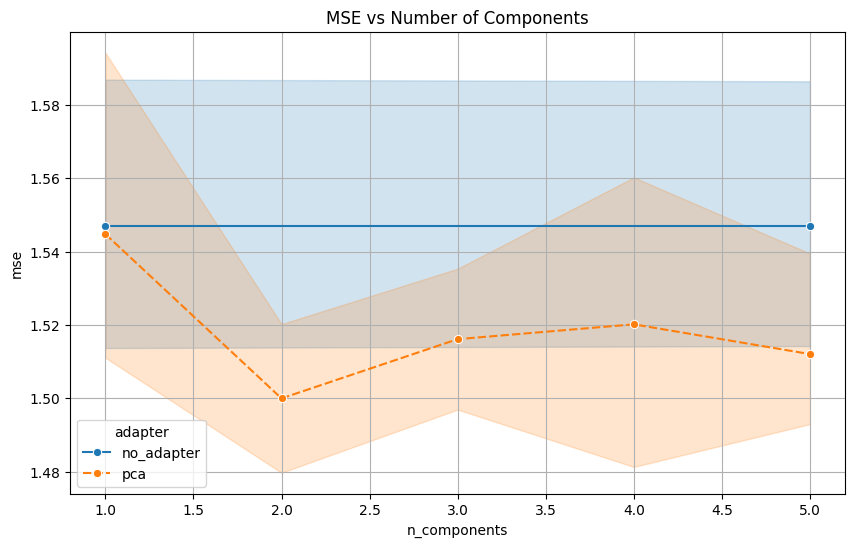

In [11]:
# plot_df(df=df, metric='mse')
plot_df(df=df1, metric="mse", adapter_list=["no_adapter", "pca"])

,adapter,n_components,seed,mse,mae,scaled_mse,scaled_mae
0,no_adapter,5,202,1.566072,0.967258,1.114803,0.891297
1,no_adapter,5,915,1.615309,0.988295,1.138388,0.909122
2,no_adapter,5,990,1.523145,0.948394,1.079549,0.875094
3,no_adapter,5,856,1.594163,0.970754,1.113281,0.894182
4,no_adapter,5,911,1.492470,0.930787,1.018827,0.852202


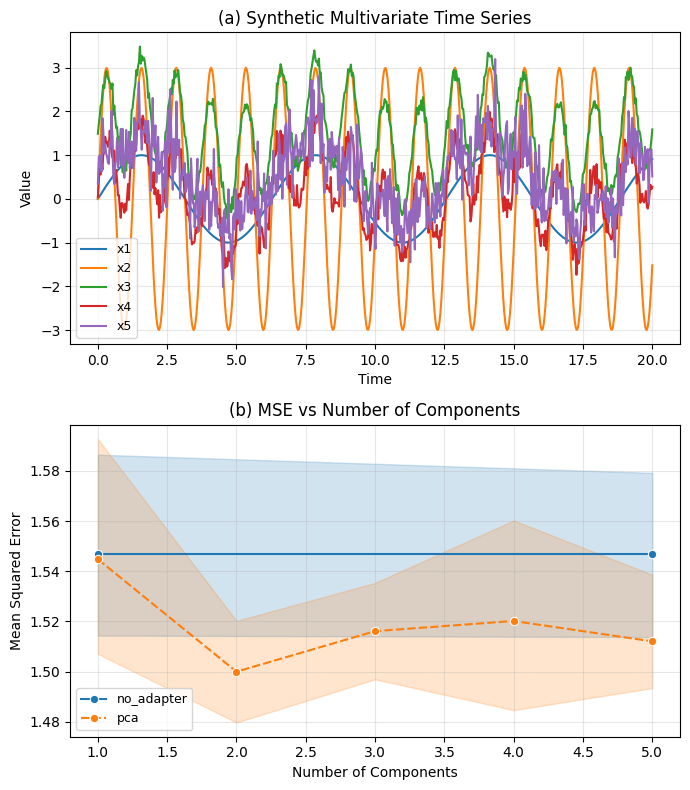

In [16]:
# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(7, 8))

# First subplot - Synthetic time series
for col in ["x1", "x2", "x3", "x4", "x5"]:
    ax1.plot(multivariate_ts["time"], multivariate_ts[col], label=col)
ax1.set_title("(a) Synthetic Multivariate Time Series", fontsize=12)
ax1.set_xlabel("Time", fontsize=10)
ax1.set_ylabel("Value", fontsize=10)
ax1.legend(fontsize=9)
ax1.grid(True, alpha=0.3)

# Second subplot - MSE vs Components
df1["adapter"] = df1["adapter"].fillna("no_adapter")
sns.lineplot(
    data=df1.loc[df1["adapter"].isin(["no_adapter", "pca"])],
    x="n_components",
    y="mse",
    hue="adapter",
    style="adapter",
    marker="o",
    ax=ax2,
)
ax2.set_title("(b) MSE vs Number of Components", fontsize=12)
ax2.set_xlabel("Number of Components", fontsize=10)
ax2.set_ylabel("Mean Squared Error", fontsize=10)
ax2.grid(True, alpha=0.3)
ax2.legend(fontsize=9)

# Adjust layout and display
plt.tight_layout()
plt.savefig(
    "/mnt/vdb/abenechehab/dicl-adapters/figures/from_notebooks/synthetic.pdf",
    dpi=300,
    bbox_inches="tight",
)
plt.show()